### Import Statements

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import os , math
from matplotlib import pyplot as plt
from scipy import stats

In [44]:
# setting seaborn as the default style
sns.set_theme() 

### Define Constants

In [45]:
DATA_FOLDER = "../data/external"
SIERRALEONE_BUMBUNA_PATH = os.path.join(DATA_FOLDER , 'sierraleone-bumbuna.csv')

### Load the data

In [46]:
sierraleone_df = pd.read_csv(SIERRALEONE_BUMBUNA_PATH)

### 1) Data cleaning

##### Show the percentage of null values for each column of the respective dataframes

In [47]:
# find the percentage of missing values for each column
sierraleone_total = sierraleone_df.shape[0]
(sierraleone_df.isnull().sum() / sierraleone_total) * 100

Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: float64

##### - It is clear that the column 'Comments' is 100% missing so removing it will not cause any harm on further steps. Hence let us remove it

In [48]:
sierraleone_df = sierraleone_df.drop(columns=['Comments'])

##### Describe the type of columns

In [49]:
sierraleone_df.dtypes

Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
dtype: object

Simple Discriptive statistics

In [50]:
sierraleone_df.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000
mean,201.957515,116.376337,113.720571,206.643095,198.114691,26.319394,79.448857,1.146113,1.691606,0.363823,133.044668,7.172220,999.876469,0.000967,0.004806,32.504263,32.593091
std,298.495150,218.652659,158.946032,300.896893,288.889073,4.398605,20.520775,1.239248,1.617053,0.295000,114.284792,7.535093,2.104419,0.031074,0.047556,12.434899,12.009161
min,-19.500000,-7.800000,-17.900000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000
25%,-2.800000,-0.300000,-3.800000,0.000000,0.000000,23.100000,68.700000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.500000,23.800000
50%,0.300000,-0.100000,-0.100000,3.600000,3.400000,25.300000,85.400000,0.800000,1.600000,0.400000,161.500000,6.200000,1000.000000,0.000000,0.000000,26.600000,26.900000
75%,362.400000,107.000000,224.700000,359.500000,345.400000,29.400000,96.700000,2.000000,2.600000,0.600000,234.100000,12.000000,1001.000000,0.000000,0.000000,40.900000,41.300000
max,1499.000000,946.000000,892.000000,1507.000000,1473.000000,39.900000,100.000000,19.200000,23.900000,4.100000,360.000000,98.400000,1006.000000,1.000000,2.400000,72.800000,70.400000


Put the target cols , categorical cols and quantitiave cols name in separate lists

In [51]:
# categorical columns
CATAGORGICAL_COLS = ["Timestamp" , "Cleaning"]

# quantitative columns
QUANTITATIVE_COLS = [col for col in sierraleone_df.columns if col not in CATAGORGICAL_COLS]

# target columns
TARGET_COLUMNS = ["ModA" , "ModB"]

##### Plot box plots for each column to show the shape of their distribution and also outliers if they are present

In [52]:
# max number of columns per subplot
MAX_COLUMNS = 6

# calculate the number of rows
num_rows = math.ceil(len(QUANTITATIVE_COLS) / MAX_COLUMNS)

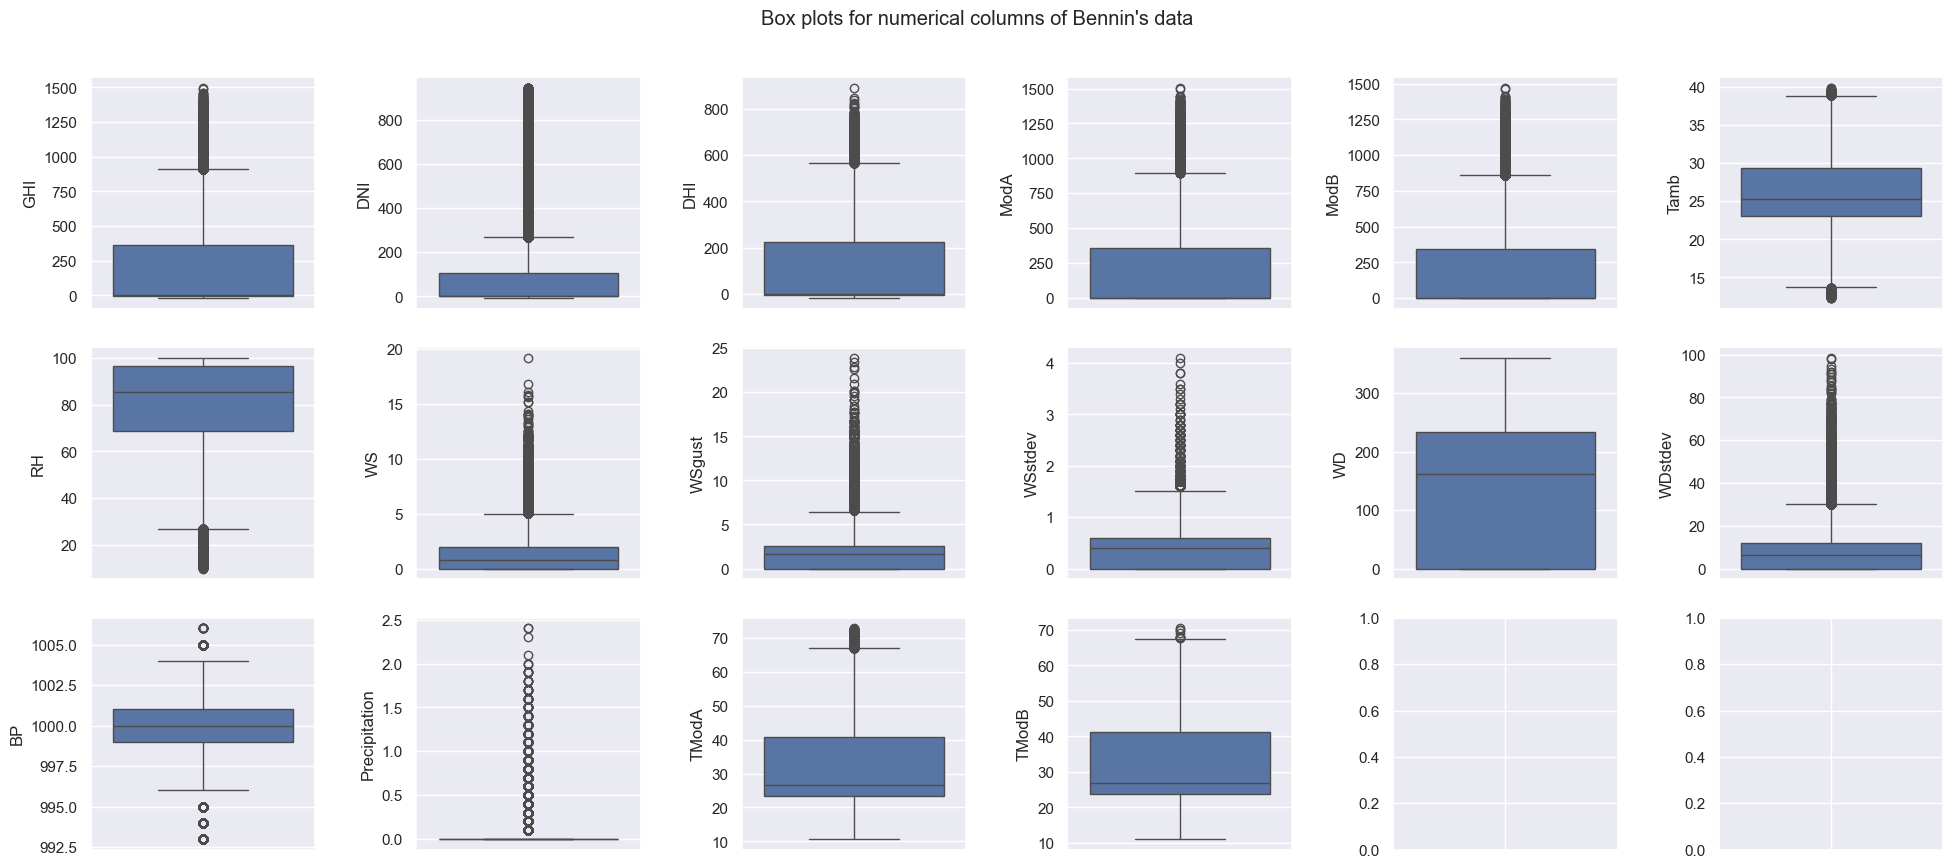

In [53]:
# subplot for bennin_df box plots
fig , axes = plt.subplots(ncols=MAX_COLUMNS , nrows=num_rows , sharex=True , figsize=(20,3 * num_rows) , squeeze=True)
fig.suptitle("Box plots for numerical columns of Bennin's data")

axes = axes.flatten()

for idx, col_name in enumerate(QUANTITATIVE_COLS):
    # Check if col_name exists in the DataFrame
    if col_name in sierraleone_df.columns:
        sns.boxplot(data=sierraleone_df[col_name].astype(float), ax=axes[idx], orient='v')
    else:
        print(f"Column {col_name} does not exist in the DataFrame.")

# Adjust spacing between subplots
plt.tight_layout(pad=2)    

##### From the above plots we can conclude that most of our features don't follow normal distribution , rather they have a right-skewed distribution. And all of the features have outlires that need to be delt with if not explained

#### Removing outliers from the data

In [55]:
# the upper-limit z-score allowed for all data
THRESHOLD = 3

# create mask for filtering data points based on z-score threshold
sierraleone_zscore_mask = np.abs(stats.zscore(sierraleone_df.drop(columns=CATAGORGICAL_COLS)) < THRESHOLD).all(axis = 1)

# apply mask to the dataframes
sierraleone_df_filtered = sierraleone_df[sierraleone_zscore_mask]

In [56]:
# calculate the perecentage of data droped because they are outliers
sieerraleone_removed = 100 - ((sierraleone_df_filtered.shape[0] / sierraleone_df.shape[0]) * 100)

print(f"Removed {sieerraleone_removed}% of data from Bennin dataset")

Removed 4.805936073059357% of data from Bennin dataset


In [57]:
sierraleone_df_filtered.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
count,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000,500340.000000
mean,180.974005,101.333269,106.692715,185.597009,177.722519,26.169002,79.933030,1.076174,1.590255,0.346248,129.792907,6.639723,999.877078,0.001011,0.001539,31.785329,31.925477
std,275.334550,198.198934,153.032700,277.953689,266.253733,4.371134,20.367219,1.151664,1.493098,0.279162,114.309386,6.818299,2.102773,0.031785,0.012311,11.869531,11.527033
min,-15.900000,-4.800000,-16.700000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000
25%,-3.500000,-0.300000,-4.200000,0.000000,0.000000,23.100000,69.400000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.400000,23.700000
50%,-0.500000,-0.100000,-0.700000,0.800000,0.700000,25.100000,86.200000,0.800000,1.400000,0.400000,153.200000,5.600000,1000.000000,0.000000,0.000000,26.200000,26.500000
75%,321.800000,65.500000,214.500000,317.900000,305.300000,29.100000,96.900000,1.900000,2.600000,0.500000,232.100000,11.600000,1001.000000,0.000000,0.000000,39.200000,39.600000
max,1097.000000,772.300000,590.500000,1105.000000,1064.000000,39.500000,100.000000,4.800000,6.400000,1.200000,360.000000,29.700000,1006.000000,1.000000,0.100000,69.800000,67.400000


From the above description we can see that the GHI , DNI and DHI range from some negative value to positive value. But how ? Since they are measures of solar energy recieved from the sun , negative values mean that somehow the sensors/modules are giving out radiaton. So to investigate this let us plot the changes over different hours of the day.  

In [58]:
# breakdown the timestamp into hours of the day and also month of the year
sierraleone_df['Timestamp'] = pd.to_datetime(sierraleone_df['Timestamp'])
sierraleone_df['Hour'] = sierraleone_df['Timestamp'].dt.hour
sierraleone_df['Month'] = sierraleone_df['Timestamp'].dt.month

In [59]:
# filter data points that have negative GHI
ghi_df = sierraleone_df[(sierraleone_df['GHI'] < 0)]

# filter data points that have negative DNI
dni_df = sierraleone_df[(sierraleone_df['DNI']) < 0]

# filter data pionts that hve negative DHI
dhi_df = sierraleone_df[(sierraleone_df['DHI']) < 0]


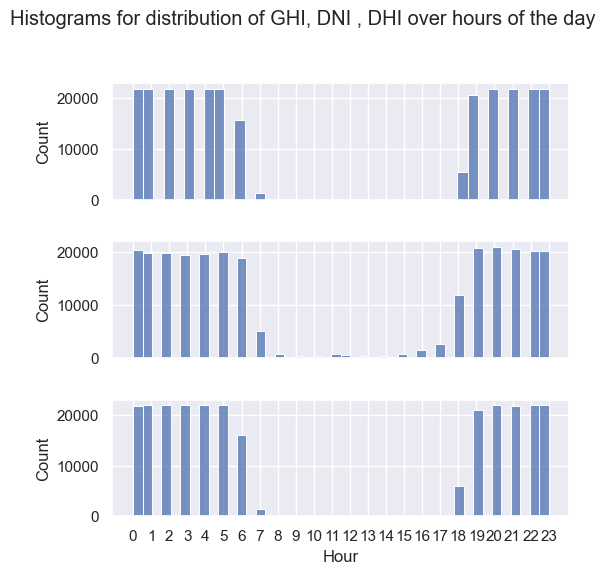

In [61]:
# subplot for togo_df box plots
fig , axes = plt.subplots(ncols=1 , nrows=3 , sharex=True , figsize=(6,6) , squeeze=True)
fig.suptitle("Histograms for distribution of GHI, DNI , DHI over hours of the day")

sns.histplot(data=ghi_df , x='Hour' , ax=axes[0])
sns.histplot(data=dni_df , x='Hour' , ax=axes[1])
sns.histplot(data=dhi_df , x='Hour' , ax=axes[2])

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(sierraleone_df['Hour'].min(), sierraleone_df['Hour'].max() + 1, 1))

# Adjust spacing between subplots
plt.tight_layout(pad=2)

So from the above histograms we can see that we get these readings with these time intervals :
* &nbsp; 0 - 7 which is from 12 AM midnight to 7 AM in the morning
* &nbsp; 18 - 23 which is from 6 PM afternoon to 5 PM 

So basically this will cover 50% of the day where we will have negative readings from our sensors.

Now let us investigate the vales that are negative, i.e have a look at their max , min , mean , 1st upto 3rd quartiles and the like

In [62]:
ghi_df['GHI'].describe()

count    261135.000000
mean         -4.929759
std           4.292342
min         -19.500000
25%          -9.300000
50%          -2.900000
75%          -1.100000
max          -0.100000
Name: GHI, dtype: float64

In [63]:
dni_df['DNI'].describe()

count    266352.000000
mean         -0.290856
std           0.218213
min          -7.800000
25%          -0.400000
50%          -0.300000
75%          -0.100000
max          -0.100000
Name: DNI, dtype: float64

In [64]:
dhi_df["DHI"].describe()

count    263128.000000
mean         -5.099848
std           4.014114
min         -17.900000
25%          -8.700000
50%          -3.800000
75%          -1.400000
max          -0.100000
Name: DHI, dtype: float64

So from the values we can see that the measures of Negative irradiation are minute. And by doing some research we can safely say that this occurs mostly because if:
1. The sensors are reading radiation of the heat descipated from the hot sensors and equipments from being exposed in the sun all day
2. There is calibration error for the equipments that leads to zero erorr , and error that occurs when instruments read small data while they are supposed to display zero

To further see this we can plot the Temprature of ModA and ModB along hours of the day.

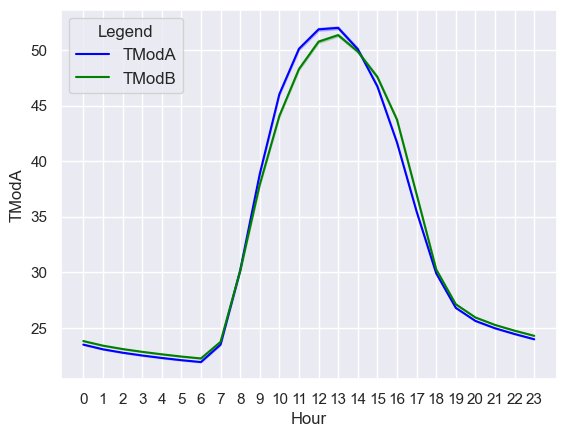

In [65]:
sns.lineplot(data=sierraleone_df , x="Hour" , y="TModA" , color="blue" , label="TModA")
sns.lineplot(data=sierraleone_df , x="Hour" , y="TModB" , color="green" , label="TModB")

# Customize the x-axis to increment by 1
plt.xticks(ticks=range(sierraleone_df['Hour'].min(), sierraleone_df['Hour'].max() + 1, 1))

# show legend
plt.legend(loc='upper left', fontsize='medium', title='Legend')

# Show the plot
plt.show()

You can see that even at night time there is some resedual heat the Modules cary so the negative readings on irradiations come from this.
So the best soution I belive to do is to replace all the negative values with zeros , since that is what they should be reading anyways

In [66]:
sierraleone_df['GHI'] = sierraleone_df['GHI'].clip(lower=0)
sierraleone_df['DNI'] = sierraleone_df['DNI'].clip(lower=0)
sierraleone_df['DHI'] = sierraleone_df['DHI'].clip(lower=0)

### 2) Univariate Analysis

- Count different classes for categorical columns , we have one categorical column which is the 'cleaning' column

In [67]:
sierraleone_df['Cleaning'].value_counts() / sierraleone_df.shape[0] * 100

Cleaning
0    99.903349
1     0.096651
Name: count, dtype: float64

We can see that 99.9 percent of our data didn't have there sensor/module cleaned when the data was collected. So basically the information we get from this column is uniform for pretty much every data point and any insight we want to get about our targets is most likely not related to this field. This column is a **_quasi constant_** variable. So we should drop it. 

In [68]:
sierraleone_df = sierraleone_df.drop(columns=['Cleaning'])

- Now for our remaining categorical data let us do some time series analysis

1) First let us create a line plot for every feature , relative to time of day

In [69]:
categorical_cols = ['Hour' , 'Timestamp' , 'Month']
numerical_cols = [col for col in sierraleone_df.columns if col not in categorical_cols]

# max number of columns per subplot
MAX_COLUMNS = 3

# calculate the number of rows
num_rows = math.ceil(len(numerical_cols) / MAX_COLUMNS)

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_66164\3098341034.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize='medium', title='Legend')


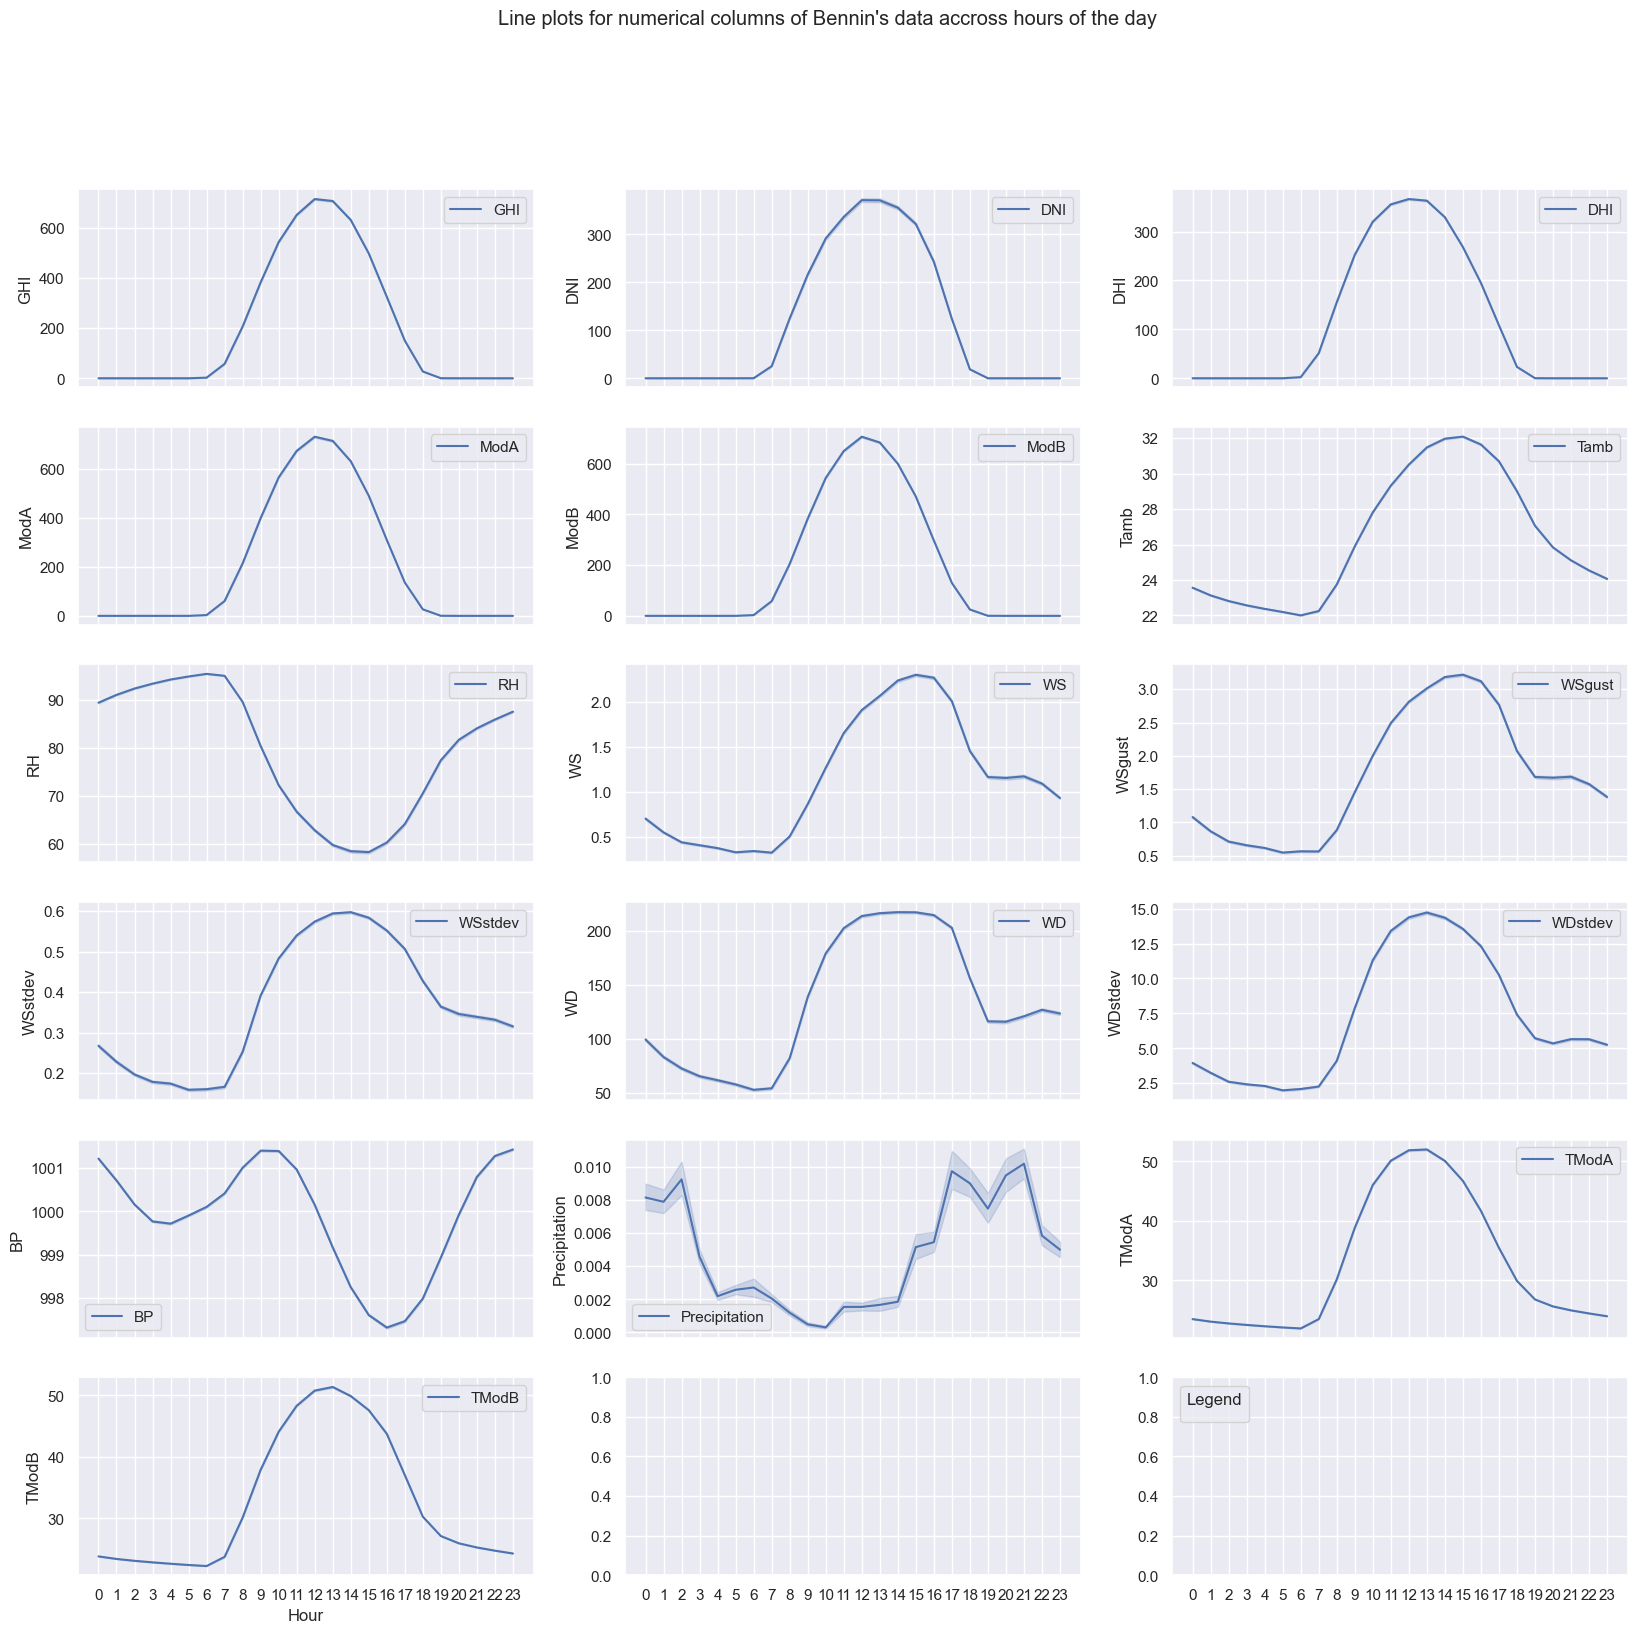

In [70]:
# subplot for sierraleone_df line plots
fig , axes = plt.subplots(ncols=MAX_COLUMNS , nrows=num_rows , sharex=True , figsize=(20,3 * num_rows) , squeeze=True)
fig.suptitle("Line plots for numerical columns of Bennin's data accross hours of the day")

axes = axes.flatten()

for idx, col_name in enumerate(QUANTITATIVE_COLS):
    # Check if col_name exists in the DataFrame
    if col_name in numerical_cols:
        # plot bennin
        sns.lineplot(data=sierraleone_df , x='Hour' , y=col_name, label=col_name , ax=axes[idx])
    else:
        print(f"Column {col_name} does not exist in the DataFrame.")


# Customize the x-axis to increment by 1
plt.xticks(ticks=range(sierraleone_df['Hour'].min(), sierraleone_df['Hour'].max() + 1, 1))

# show legend
plt.legend(loc='upper left', fontsize='medium', title='Legend')

# Show the plot
plt.show()

From the above line plots we can see that most of our features/columns have a trends that follows a specific time window. For example you can see that columns like:
* GHI
* DNI
* DHI
* ModA
* ModB
* WDstdev,

usually are flat from 0 - 7 (12 PM - 7 AM) then uniformly rise to their max value at about 12 AM then gradually return to flat(min value) at about 18 (6 PM) and stay the same upto 23(11 PM).

Now let us try and find similar trends over the months of the year

C:\Users\VICTUS 16\AppData\Local\Temp\ipykernel_66164\2428289778.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', fontsize='medium', title='Legend')


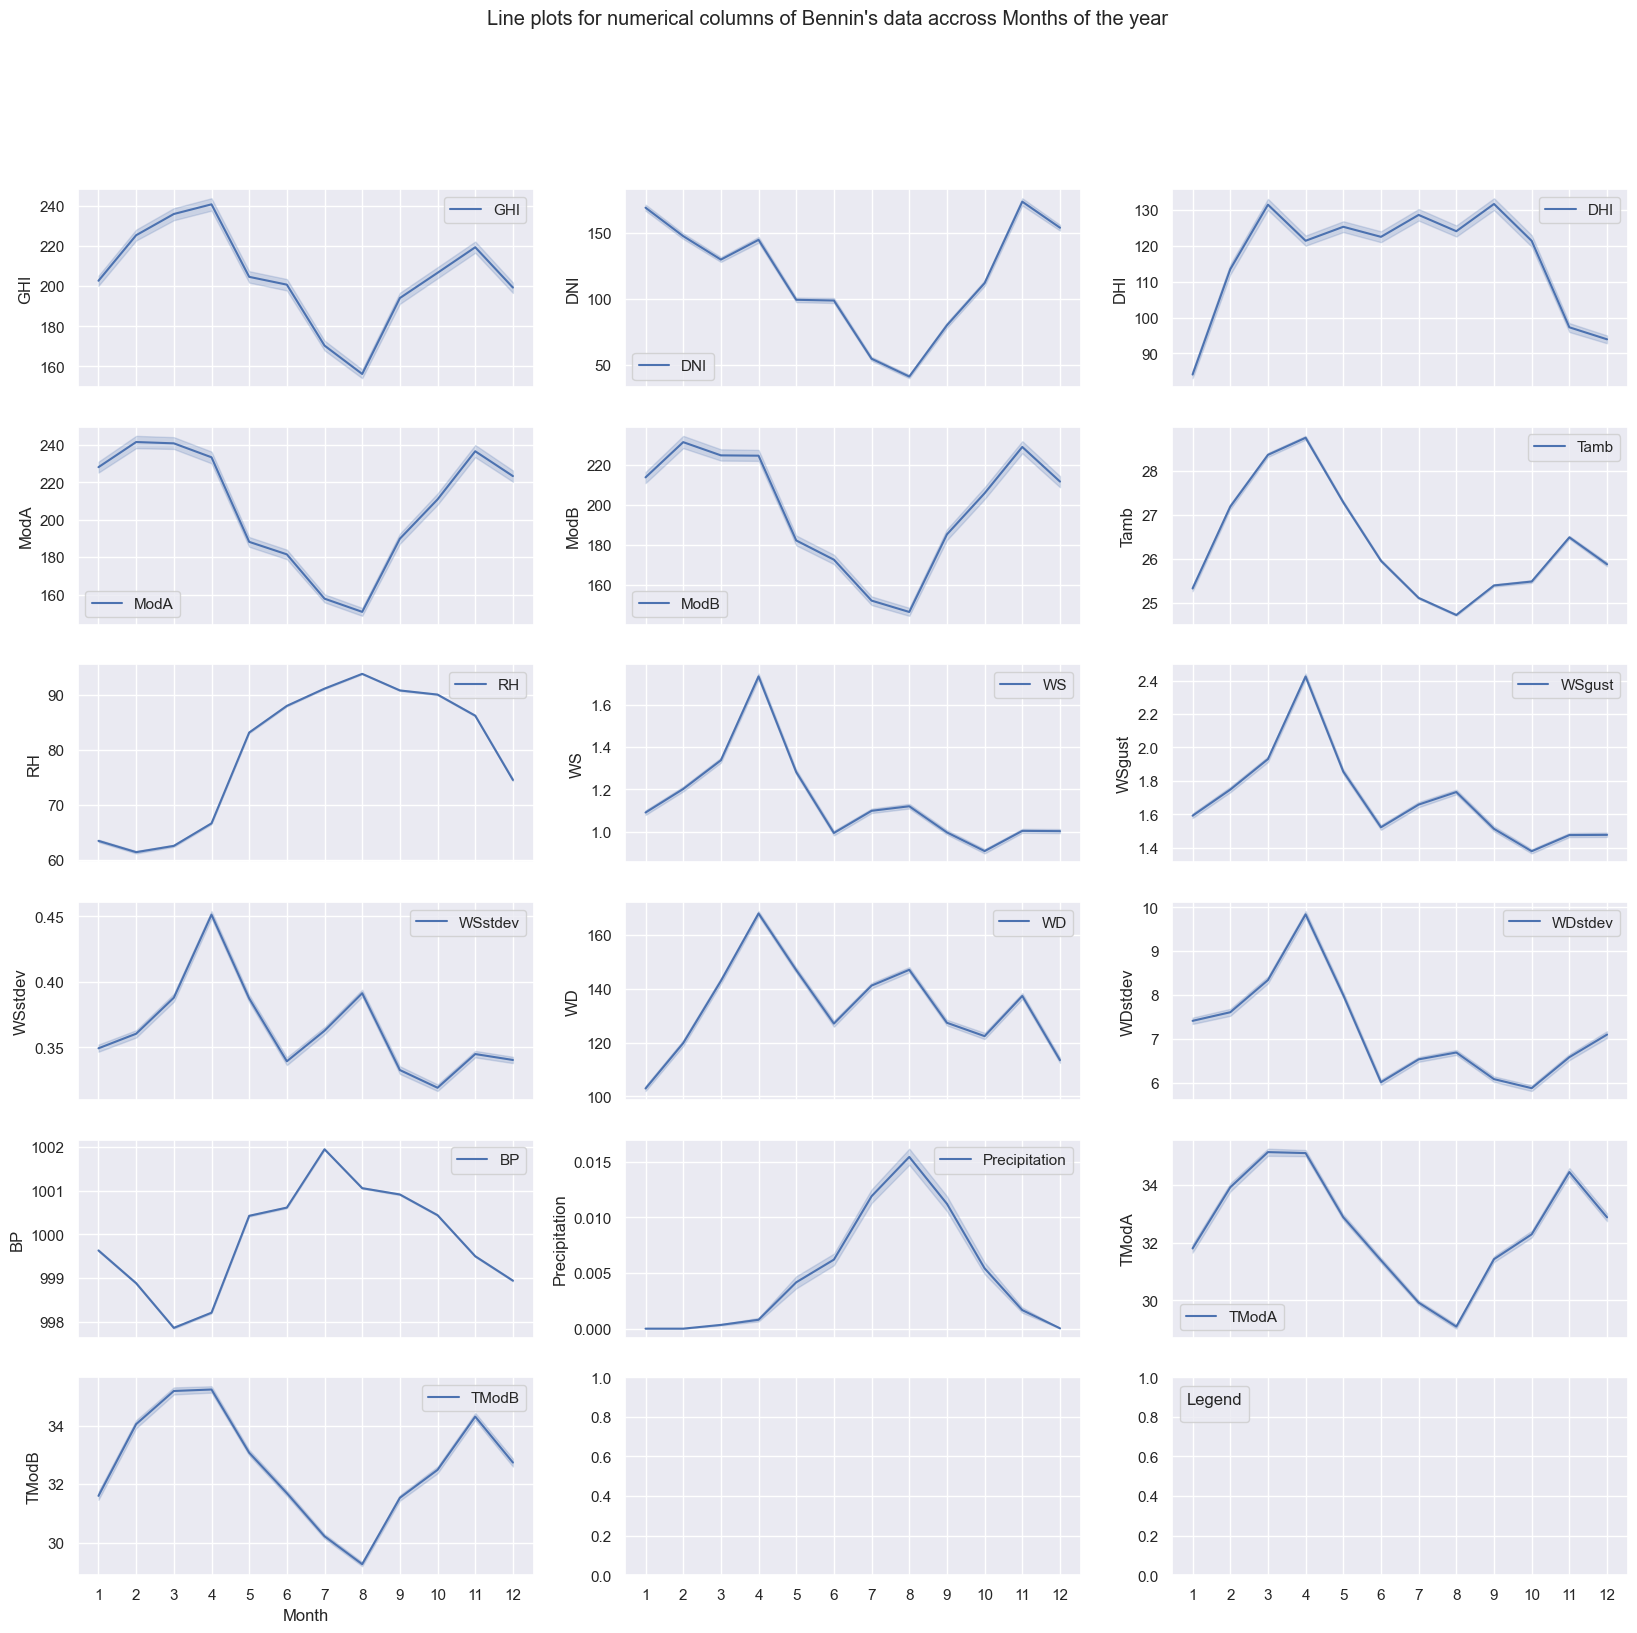

In [71]:
# subplot for sierraleone_df line plots
fig , axes = plt.subplots(ncols=MAX_COLUMNS , nrows=num_rows , sharex=True , figsize=(20,3 * num_rows) , squeeze=True)
fig.suptitle("Line plots for numerical columns of Bennin's data accross Months of the year")

axes = axes.flatten()

for idx, col_name in enumerate(QUANTITATIVE_COLS):
    # Check if col_name exists in the DataFrame
    if col_name in numerical_cols:
        # plot bennin
        sns.lineplot(data=sierraleone_df , x='Month' , y=col_name, label=col_name , ax=axes[idx])
    else:
        print(f"Column {col_name} does not exist in the DataFrame.")


# Customize the x-axis to increment by 1
plt.xticks(ticks=range(sierraleone_df['Month'].min(), sierraleone_df['Month'].max() + 1, 1))

# show legend
plt.legend(loc='upper left', fontsize='medium', title='Legend')

# Show the plot
plt.show()

From the above plot we can see that there are seasonal variations that occur like:
* **DHI** continously increases from its lowest reading upto its highest reading from month 1 - 3 (Jan - March) which is a transitions period from the heart of dry season in Sierraleone(jan) to the transition phase to wet season which is in March. Then it remains at right around the max makind some small upwards and downwrads movement from month 4-9(April - August). Then after that it gradually decrease from month 10 - 12 (Sept - December). So we can notice that it increases when there is cloud coverage. 
* **DNI** continously decreses from the highest reading to its a medium reading from months 1 - 4 (Jan - April) which is a transitions period from the heart of dry season in Sierraleone(jan) to the transition phase where the dry season ends in April. Then it shows a steep decrease up to month 8 (August) from where it again continously increases to its highest reading up to month 12 (December) which is the peak of the dryest season. We can see that there is almost no cloud coverage during dry season and almost total cloud coverage during wet season because DNI is affected heavely during those seasons.
* Both **ModA** and **ModB** have a similar pattern that increases during dry seasons and decreases during wet seasons.

We can also overlap **Precipitation** or **Relative Humidity** for all the other metrics to determine in which time period certain trends occur(dry or wet season) instead of refering online weather data like I did. The results are the same.

### 3) Multivariate Analysis

- Let us start by Correlation Matrix for our numeric features

In [28]:
correlation_matrix = sierraleone_df[numerical_cols].corr(method='pearson')

<Axes: >

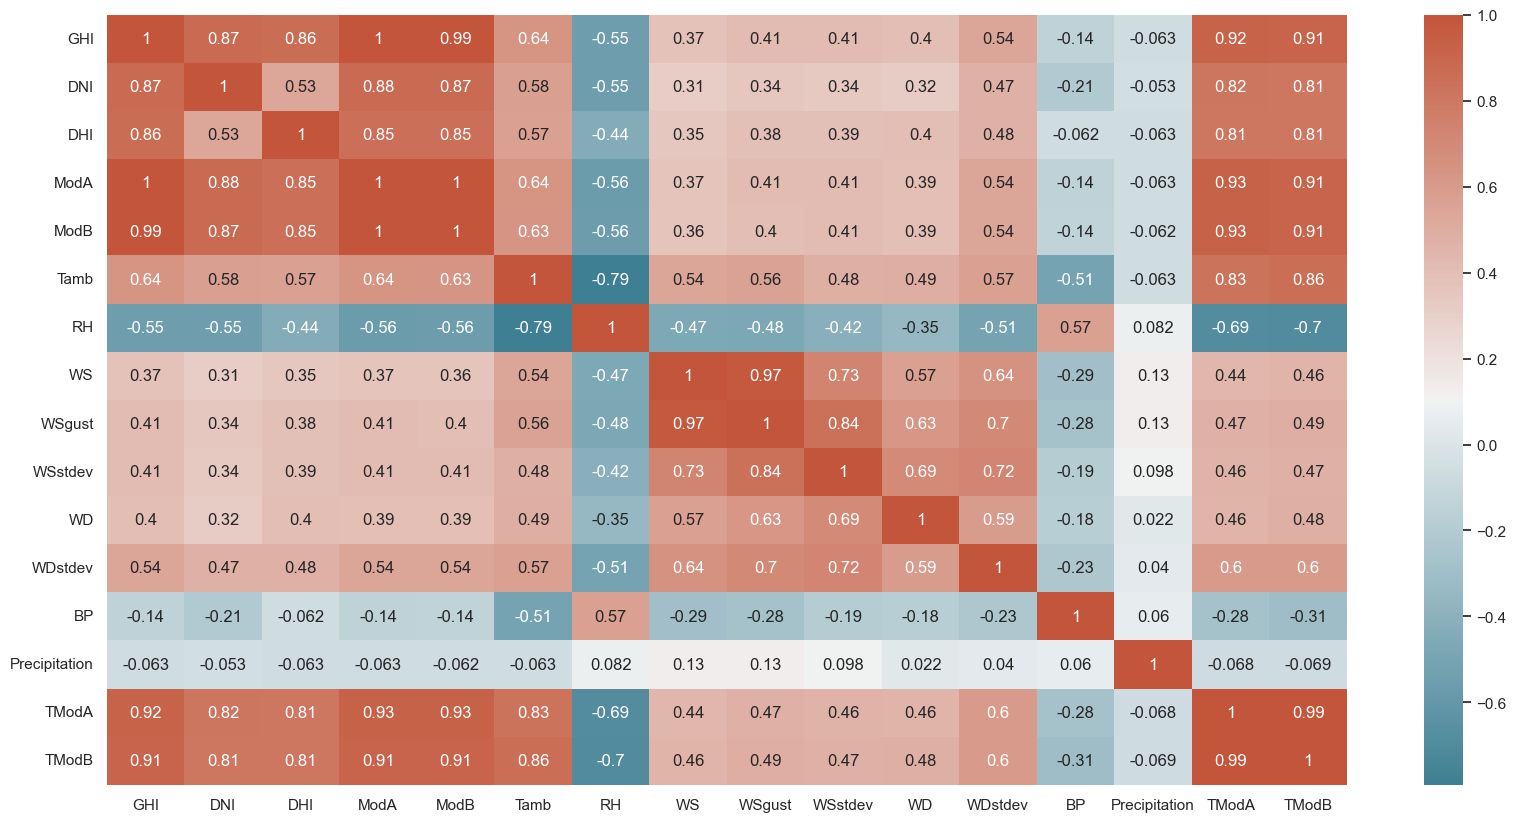

In [72]:
fig , ax = plt.subplots()
fig.set_size_inches(20 , 10)
cmap = sns.diverging_palette(220 , 20 , as_cmap=True)
sns.heatmap(correlation_matrix , cmap=cmap , annot=True)

From the heat map we can notice there are really good correlation between features. For example **GHI** has a high correlation with **DNI** , **DHI** , **MobA** , **MobB** , **TModA** and **TModB**.

But instead of just eyeballing the correlation from the heatmaps let us programmatically filter out feature pairs that have strong correlation.


In [73]:
# Create a mask to ignore self-correlations (correlation of a variable with itself)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Filter correlations that are above 0.6 or below -0.6 and not on the diagonal
filtered_corr = correlation_matrix.where(~mask & ((correlation_matrix > 0.6) | (correlation_matrix < -0.6)))

# Drop NaN values to see the significant correlations
significant_correlations = filtered_corr.stack().reset_index()

In [74]:
significant_correlations

,level_0,level_1,0
0,DNI,GHI,0.869564
1,DHI,GHI,0.863848
2,ModA,GHI,0.995113
3,ModA,DNI,0.876332
4,ModA,DHI,0.849518
5,ModB,GHI,0.994680
6,ModB,DNI,0.874823
7,ModB,DHI,0.850085
8,ModB,ModA,0.999127
9,Tamb,GHI,0.639897


Okay from the above result we can now select correlations that help us realise the decision for our business objective , which is to determine a region that has high potential to maximize solar energy farming with long term sustainability. So we need to find correlations with our target variables , i.e positive correlations with **ModA** and **ModB** readings.

Here are the columns/features that have postivie/negative correlation with **ModA** and **ModB**:
* **DHI** (0.828884 with **ModA** & 0.826838 with **ModB** )
* **DNI** (0.891879 with **ModA** & 0.891868 with **ModB**)
* **GHI** (0.994477 with **ModA** & 0.994907 with **ModB**)
* **TModA** (0.908981 with **ModA** & 0.912114 with **ModB**) (Note: Even though TModA reads the temp of ModA since they ModB & ModA are sensors on the same module they have almost the same readings hence show correlation to the other module in this case ModB)
* **TModB** (0.862234 with **ModB** & 0.856101 with **ModA**) (**Note**: Even though **TModB** reads the temp of **ModB** since they (**ModB** & **ModA**) are sensors on the same module they have almost the same readings hence show correlation to the other module in this case **ModA**)

So now let us try to visuallize and determine on which time interval (both hours of the day and months) of the year are these readings at their peak , lowest and even transitional period. To do so I will use percentiles. I chose the 75th percentile for the upper_threshold and chose 50th percentile as the lower_threshold because anything between the 0th percentile and 49th percentile had a reading of 0 for the features I was investigating. The problem of being zero is that the modules aren't getting any radiation and no power is being produced and my goal is to differentiate in which hour/month was power is being produced or where it wasn't getting produced

In [87]:
# features of interese
feat_interest = ["DHI" , "DNI" , "GHI" , "TModA" , "TModB", "ModA" , "ModB"] 

# find the 75th and 50th percentiles and use them as the upper and lower thresholds respectively
upper_threshold = sierraleone_df[feat_interest].quantile(.75)
lower_threshold = sierraleone_df[feat_interest].quantile(.50)

In [76]:
upper_threshold

DHI      224.7
DNI      107.0
GHI      362.4
TModA     40.9
TModB     41.3
ModA     359.5
ModB     345.4
Name: 0.75, dtype: float64

In [77]:
lower_threshold

DHI       0.0
DNI       0.0
GHI       0.3
TModA    26.6
TModB    26.9
ModA      3.6
ModB      3.4
Name: 0.5, dtype: float64

Now let us count the amount of time spent above those thresholds

In [78]:
sierraleone_copy = sierraleone_df.copy()

def categorize(row, col_name):
    if row[col_name] >= upper_threshold[col_name]:
        return 'High'
    elif row[col_name] <= lower_threshold[col_name]:
        return 'Low'
    else:
        return 'Middle'

resulting_cols = []
for col in feat_interest:
    resulting_cols.append(col+'_Category')
    sierraleone_copy[col + '_Category'] = sierraleone_copy.apply(categorize , col_name=col , axis=1) 

In [79]:
category_counts = sierraleone_copy[['DHI_Category', 'DNI_Category', 'GHI_Category', 'TModA_Category', 'TModB_Category' , 'ModA_Category' , 'ModB_Category']].apply(pd.Series.value_counts, normalize=True) * 100

In [80]:
category_counts

,DHI_Category,DNI_Category,GHI_Category,TModA_Category,TModB_Category,ModA_Category,ModB_Category
Low,50.130137,55.916667,50.046804,50.263699,50.392694,50.003425,50.022831
High,25.008181,25.001712,25.005708,25.012747,25.011986,25.005327,25.001142
Middle,24.861682,19.081621,24.947489,24.723554,24.595320,24.991248,24.976027


Now let us see the distribution of readings accros the months of the year and the hours of the day

In [88]:
groupings = {}
classes = ['Low' , 'Middle' , 'High']
for col in resulting_cols:
    grouping_result = sierraleone_copy.groupby(col)
    for cls in classes:
        sr_hour = pd.DataFrame(grouping_result['Hour'].get_group(cls))
        sr_month = pd.DataFrame(grouping_result['Month'].get_group(cls))
        
        # get the counts for all the unique values
        sr_hour = sr_hour.value_counts().reset_index()
        sr_month = sr_month.value_counts().reset_index()

        if col not in groupings.keys():
            groupings[col] = {cls : {'Hour' : sr_hour , 'Month' : sr_month}}
        else:
            groupings[col][cls] = {'Hour' : sr_hour , 'Month' : sr_month}

Now we can plot our bargraphs to visualize and hopefully see trends

In [89]:
# calculate the number of rows for ploting hours
total_plots = len(resulting_cols) * 3
num_rows = math.ceil(total_plots / MAX_COLUMNS)

First let us visualize them accross the hours of the day

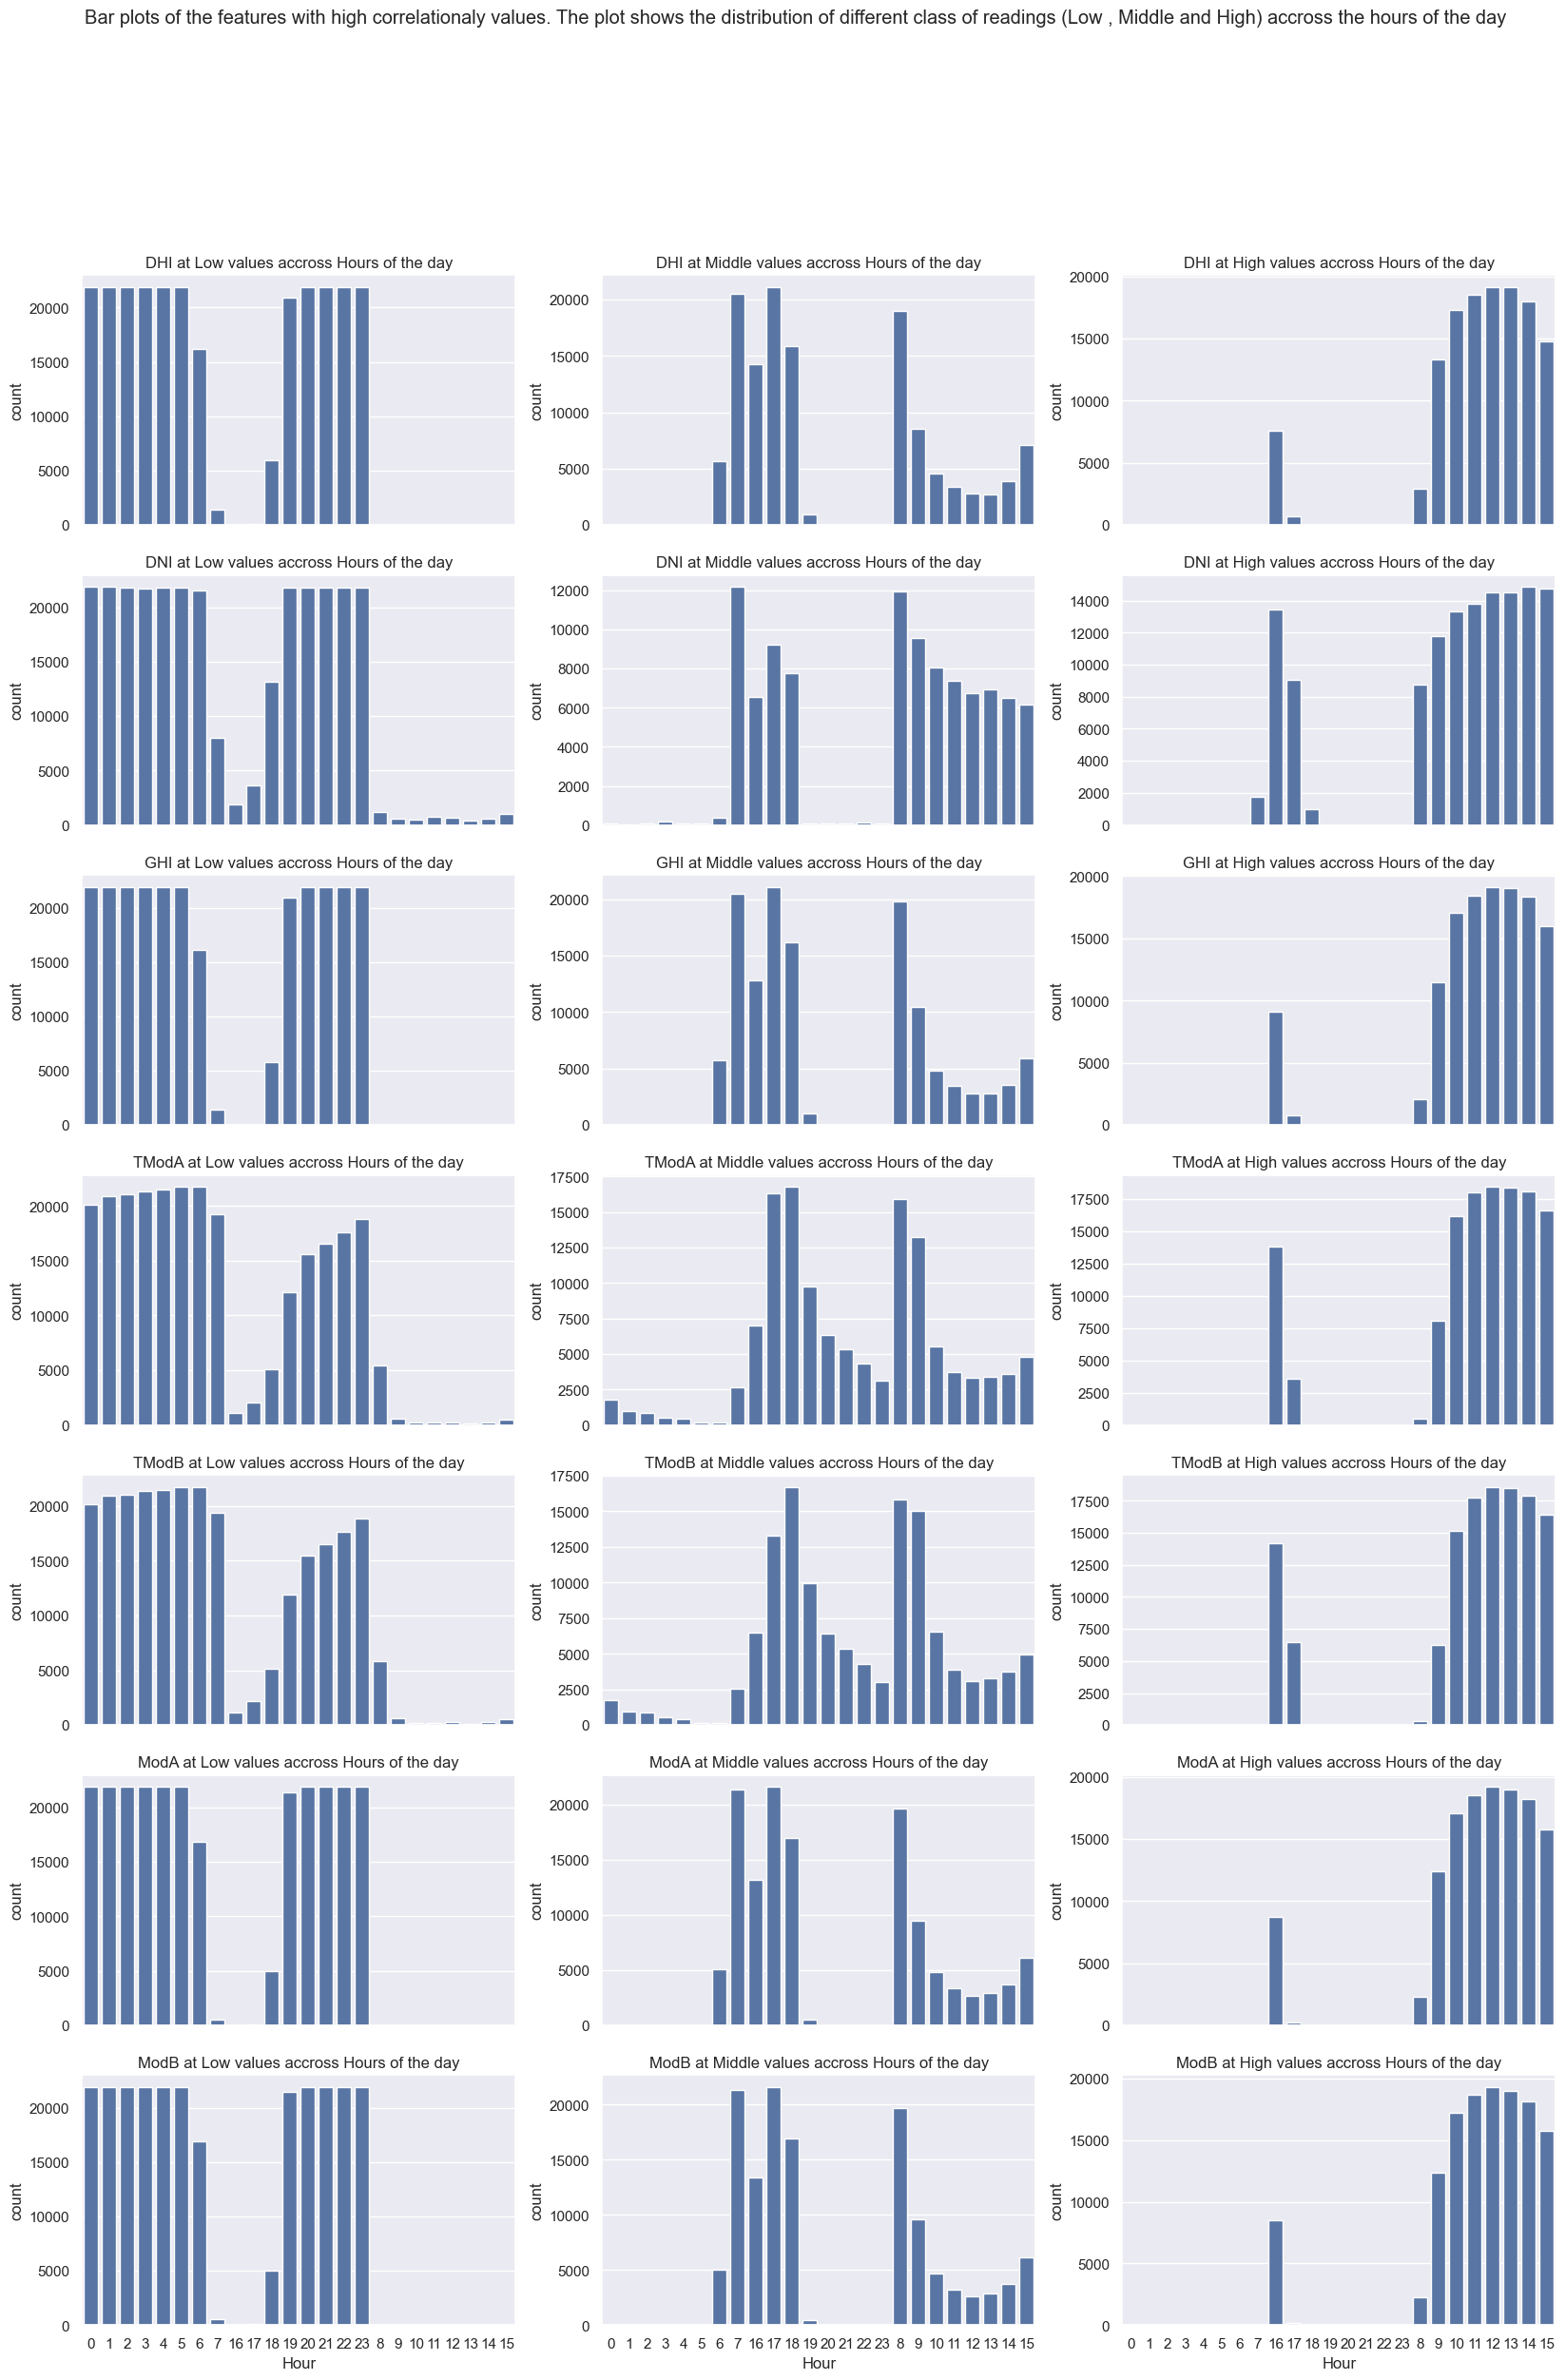

In [90]:
# subplot for sierraleone_df line plots
fig , axes = plt.subplots(ncols=MAX_COLUMNS , nrows=num_rows , sharex=True , figsize=(20,4 * num_rows) , squeeze=True)
fig.suptitle("Bar plots of the features with high correlationaly values. The plot shows the distribution of different class of readings (Low , Middle and High) accross the hours of the day")

axes = axes.flatten()
index = 0
col_idx = 0

while index < total_plots:
    col_name = resulting_cols[col_idx]
    real_name = col_name.split('_')[0]
    for cls in classes:
        data = groupings[col_name][cls]['Hour']
        sns.barplot(data=data , x='Hour' , y='count', ax=axes[index])
        axes[index].set_title(f"{real_name} at {cls} values accross Hours of the day")
        index += 1
    col_idx += 1

# Show the plot
plt.show()

From the plots we can conclude that:
* The lowest readings, which are found on the left most column of the plot, come in hours 0 - 6 (12 PM to 6 AM) , 18 - 23 (6PM to 11PM) and some counts here and there at hour 7 (7AM)
* The middle readings, which are found in the middle column of the plot, signigicantly come in hours 7 - 9 (7AM to 9AM) , 16 - 18 (4PM to 6PM) and some counts here and there 10 - 14 (10AM to 2PM)
* The high readings, which are found in the right most column of the plot, come in hours 9 - 15 (9AM to 3PM) and some counts here and there at 8 and 16 (8AM and 4PM) 

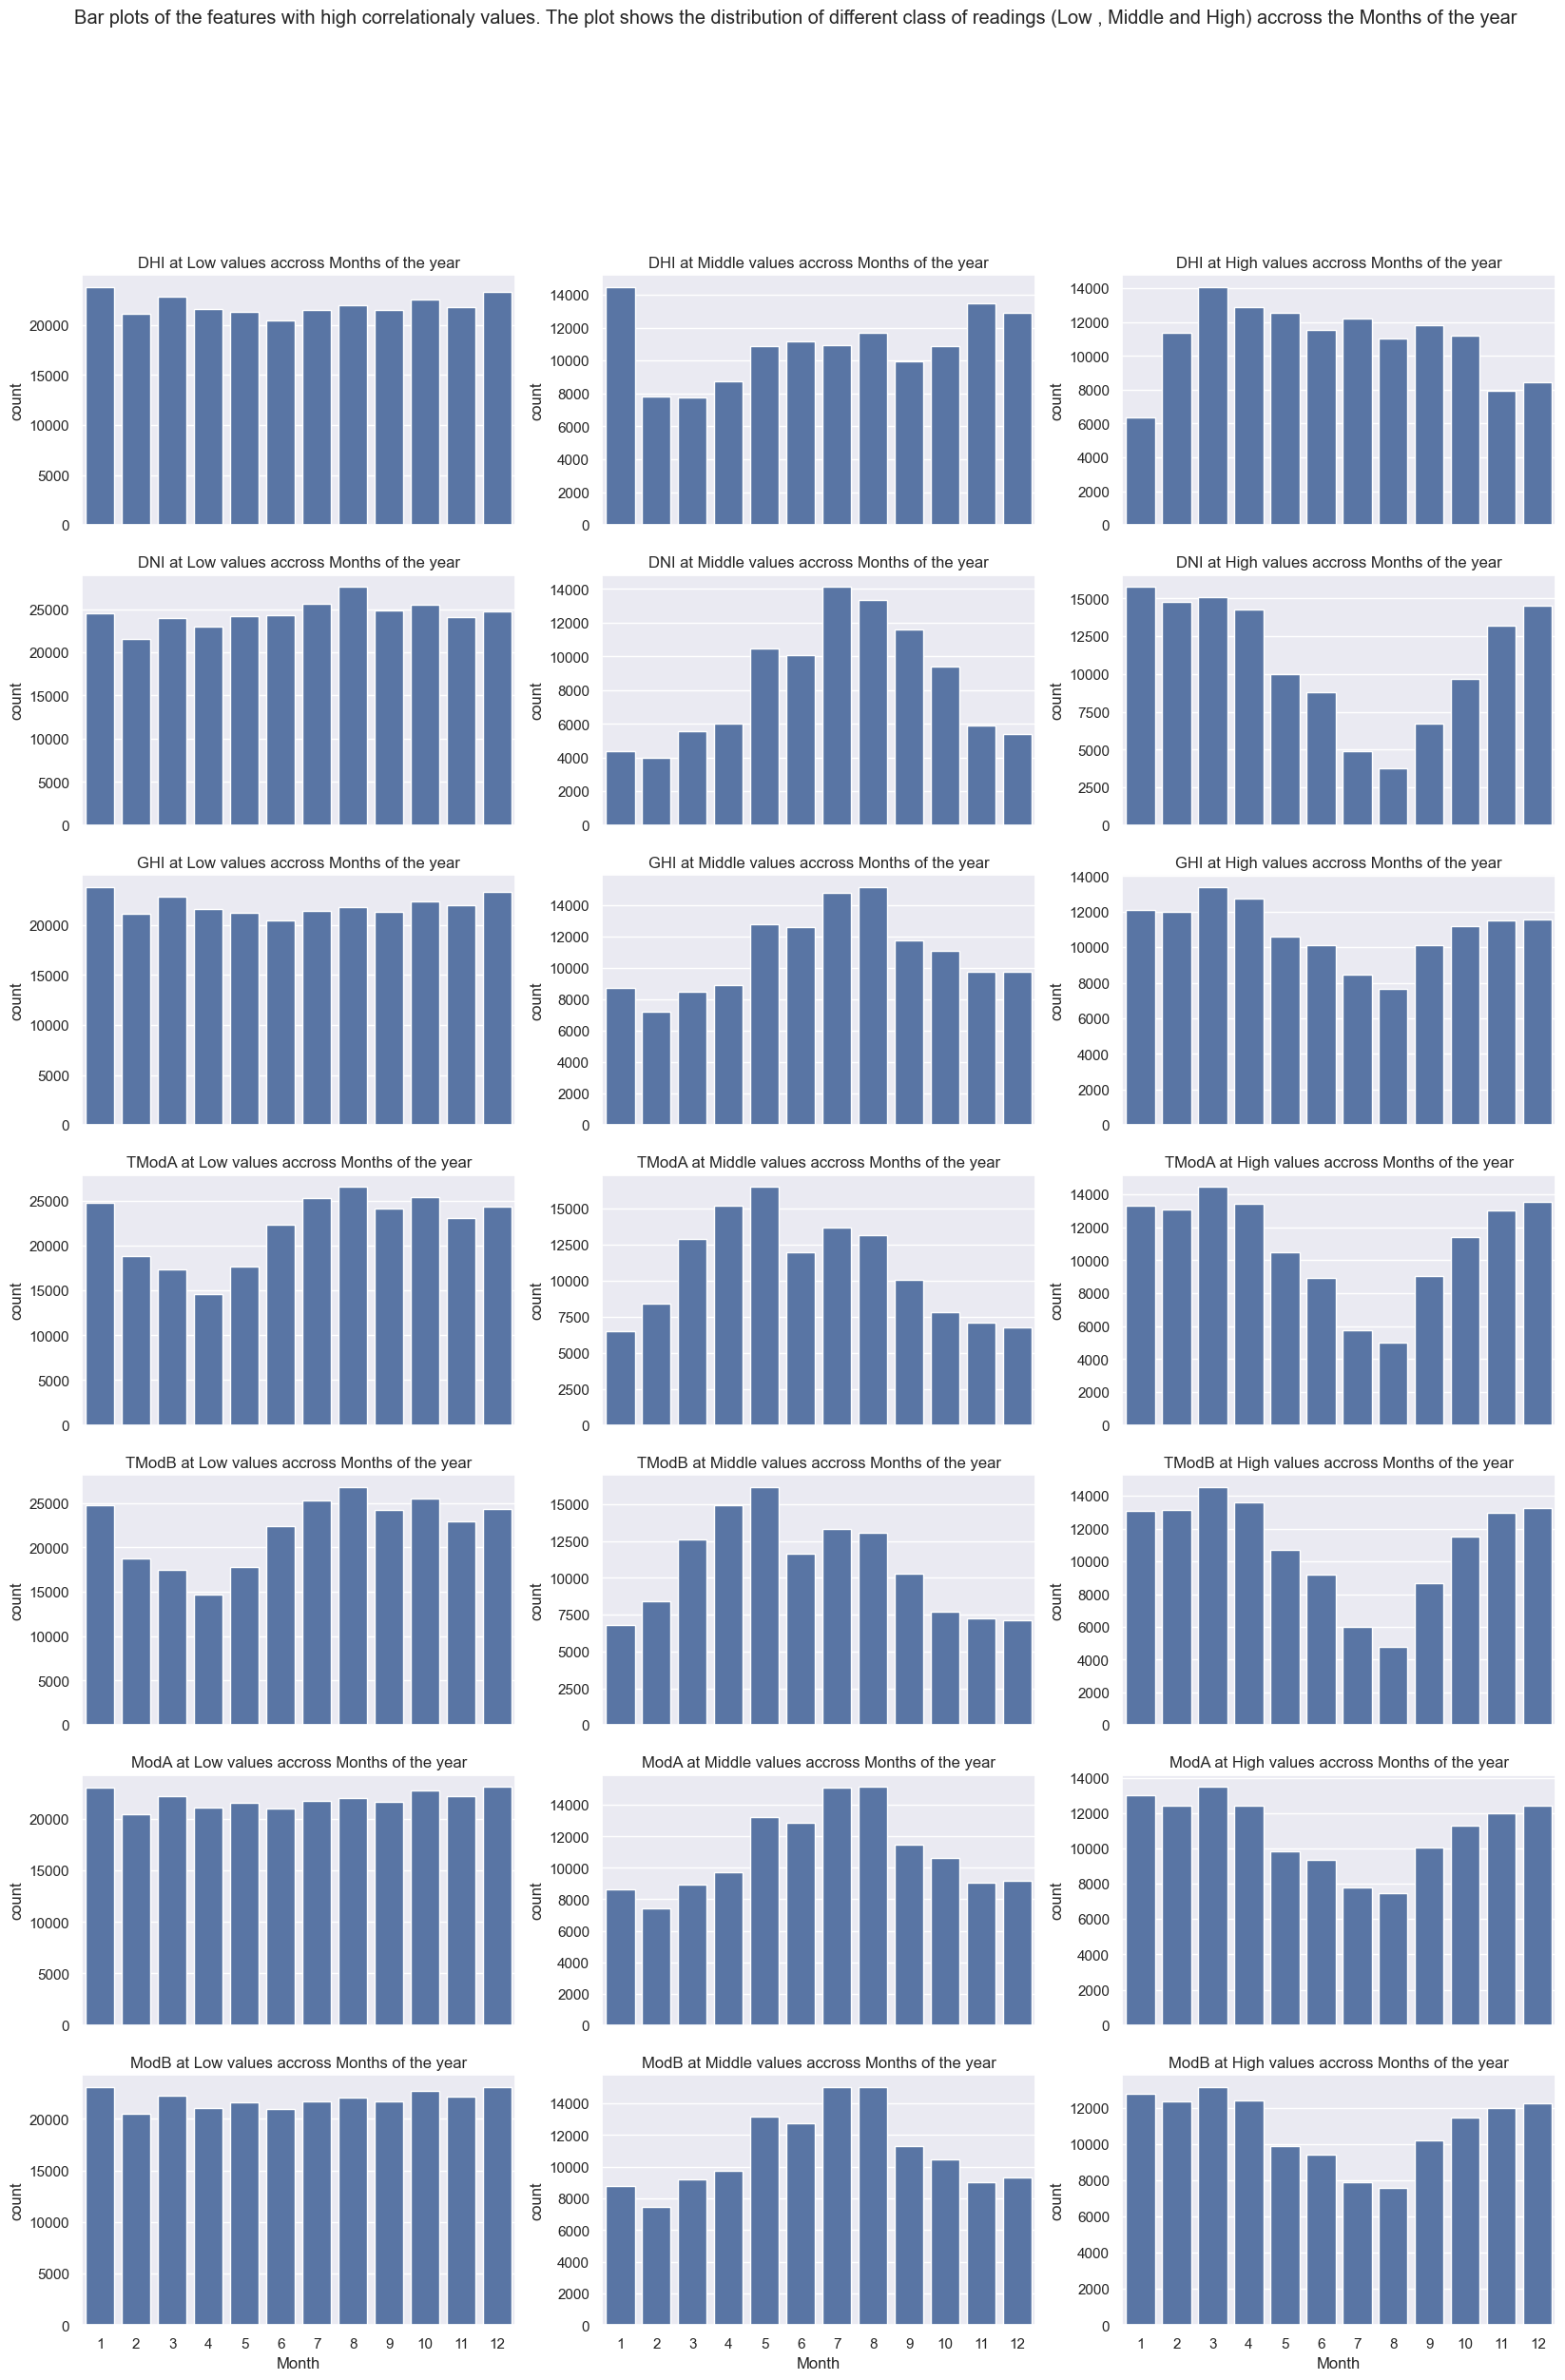

In [86]:
# subplot for sierraleone_df line plots
fig , axes = plt.subplots(ncols=MAX_COLUMNS , nrows=num_rows , sharex=True , figsize=(20,4 * num_rows) , squeeze=True)
fig.suptitle("Bar plots of the features with high correlationaly values. The plot shows the distribution of different class of readings (Low , Middle and High) accross the Months of the year")

axes = axes.flatten()
index = 0
col_idx = 0

while index < total_plots:
    col_name = resulting_cols[col_idx]
    real_name = col_name.split('_')[0]
    for cls in classes:
        data = groupings[col_name][cls]['Month']
        sns.barplot(data=data , x='Month' , y='count', ax=axes[index])
        axes[index].set_title(f"{real_name} at {cls} values accross Months of the year")
        index += 1
    col_idx += 1

# Show the plot
plt.show()

From the plots we can see that:
* The highest readings are highly observed in months except 5, 6, 7, 8, and 9 (May, June, July, August and September)
* The medium readings are highly observed in months 5 , 6 , 7 , and 8 (May, June, July and August)
* The lowest readings can be obsereved in every month.

Its probably obvious that the plots along months of the year don't show clear distinction between low , middle and high readings as the plots for hours of the day. This is because regardelss the weather/season the readings at night will always be zero and mid day will be high so the counts along different months of the year will contain values for all of the reading classification. That's why all months will have high counts of high, medium and low readings because after all we get reads of a month by aggregating the readigns of days 